In [23]:

from utils import get_resized_dims
import os
import zipfile
import torch
import random
from safetensors.torch import load
from torchvision.transforms.v2.functional import resize
from torchvision import disable_beta_transforms_warning
from pathlib import Path
from torchvision.io import decode_image
import matplotlib.pyplot as plt
from collections import Counter
import polars as pl

In [24]:
OVERRIDES = {'experiment.well':pl.String, 
             'experiment.plate':pl.String, 
             'microscopy.fov': pl.String, 
             'microscopy.magnification': pl.String, 
             'geometry.depth': pl.String,
             'geometry.z_slice': pl.String
             }

In [25]:
pl.Config.set_tbl_rows(-1)
pl.Config.set_tbl_width_chars(-1)
pl.Config.set_tbl_cols(-1)
pl.Config.set_fmt_table_cell_list_len(-1)

polars.config.Config

In [26]:
metadata_path = '~/dataset/sampling/75ds_small_meta.csv'
metadata = pl.read_csv(metadata_path, schema_overrides=OVERRIDES)

In [40]:
class GuidedCrop(object):
    def __init__(self, crop_size: tuple[int,int], crop_data: str):
        assert len(crop_size) == 2 and isinstance(crop_size[0], int) and isinstance(crop_size[1], int)
        assert isinstance(crop_data, str) and crop_data.endswith('zip')
        
        self.crop_size = crop_size
        crop_data = os.path.abspath(os.path.expanduser(crop_data))
        self.data = zipfile.ZipFile(crop_data)
        self.data_paths = set([file.filename for file in self.data.filelist if not file.is_dir()])

    def __call__(self, sample:torch.Tensor, sample_path:str) -> torch.Tensor: 
        if sample_path in self.data_paths:
            with self.data.open(sample_path) as f:
                image_height, image_width = sample.shape[1], sample.shape[2]
                
                possible_centroids = load(f.read())['data']
                chosen_centroid = possible_centroids[random.randint(0, possible_centroids.shape[0] - 1), :]
                y, x = chosen_centroid[0], chosen_centroid[1]
                crop_height, crop_width = self.crop_size[0], self.crop_size[1]  
                
                # Divide by 2, as we want half the crop size on each size of the center point
                x1, y1, x2, y2, moved = get_crop_location(crop_height//2, crop_width//2, y, x, image_height, image_width)
                
                cropped_sample = sample[:, y1:y2, x1:x2]
                return cropped_sample, moved
        else:
            raise ValueError("Sample path is not in the guided crop data. Please check why this function was called.")
        
def get_crop_location(crop_height:int, crop_width:int, y_center:int, x_center:int,  image_height: int, image_width: int):
    # subtraction goes up or left, addition goes down or right
    y1 = y_center - crop_height 
    y2 = y_center + crop_height
    x1 = x_center - crop_width
    x2 = x_center + crop_width

    pre_mod = (x1, x2, y1, y2)
    
    if y1 < 0:
        y2 = y2 - y1 # add into down direction -(-) = +
        y1 = 0
    elif y2 > image_height:
        y1 = y1 - (y2-image_height) # Move y1 up the difference
        y2 = image_height
    
    if x1 < 0:
        x2 = x2 - x1
        x1 = 0
    elif x2 > image_width:
        x1 = x1 - (x2-image_width)
        x2 = image_width
    
    moved = False    
    if pre_mod != (x1, x2, y1, y2):
        moved = True
    
    return x1, y1, x2, y2, moved

zip_path = '/scr/data/75ds_small_segmentations/CHAMMI10ds.zip'
guided = GuidedCrop((128,128), zip_path)

In [28]:
images_path = '/scr/data/CHAMMI10ds.zip'
images = zipfile.ZipFile(images_path)

In [29]:
guided.crop_size

(128, 128)

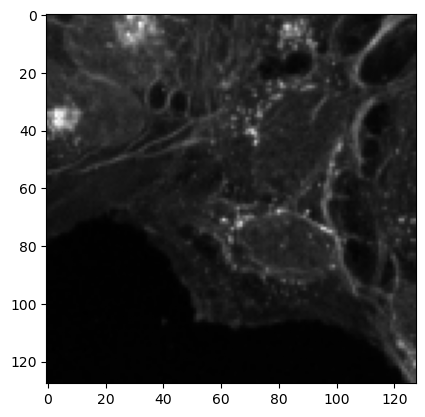

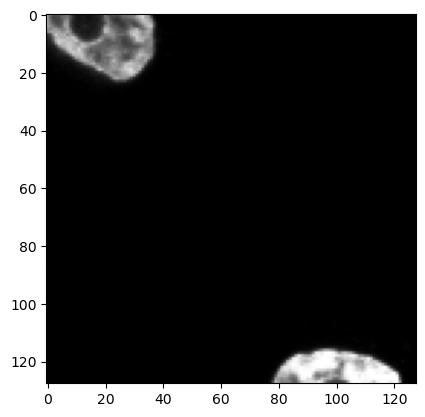

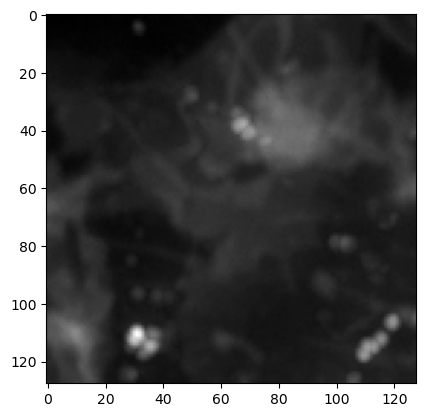

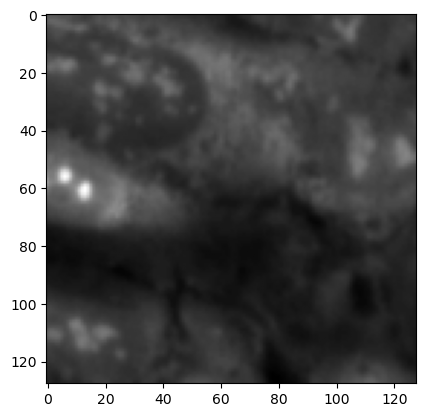

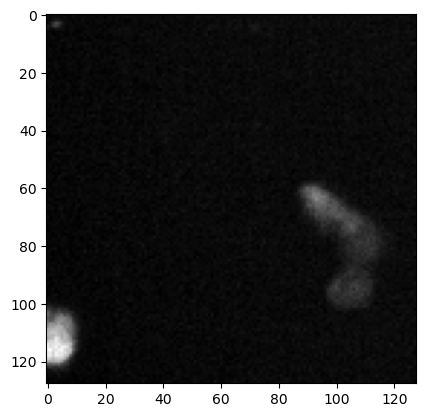

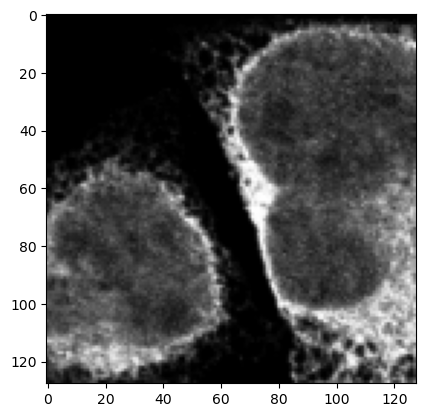

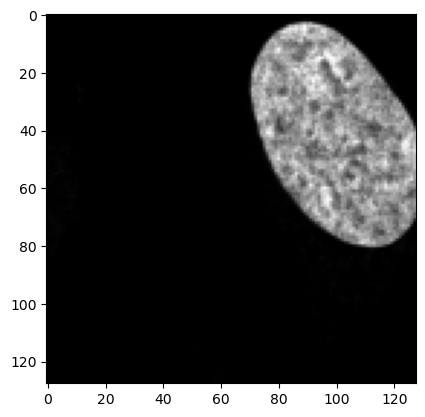

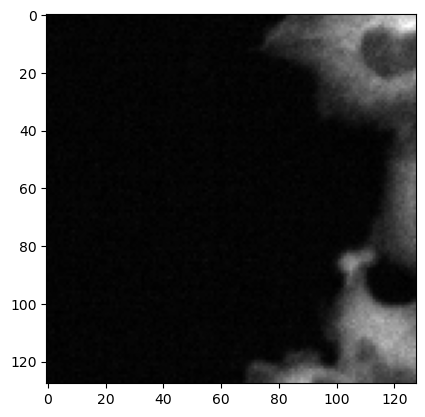

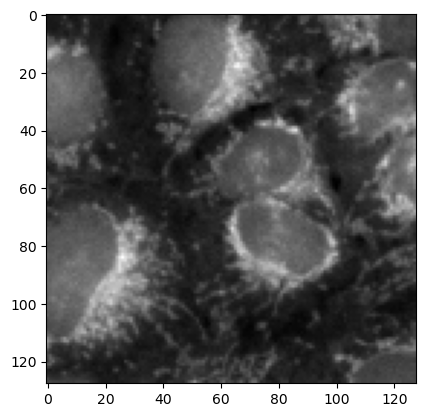

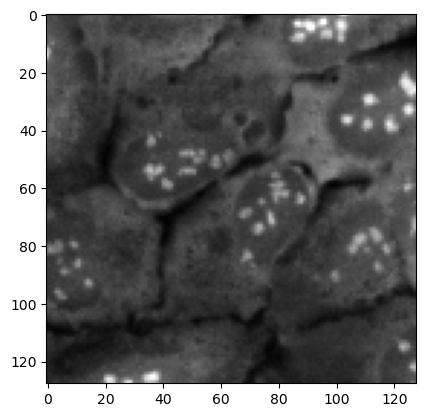

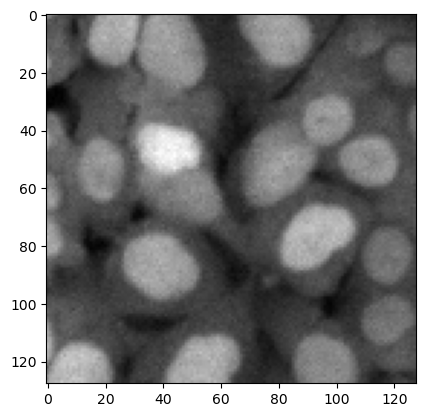

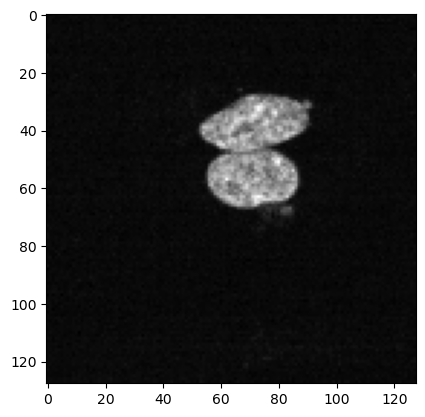

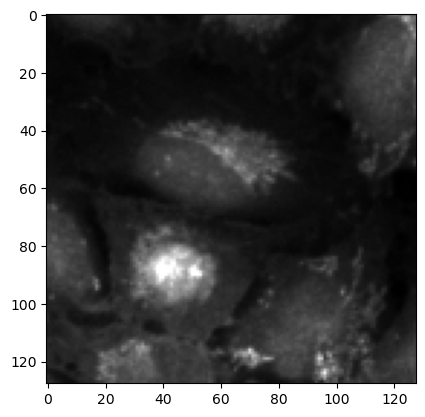

In [41]:
study_filecounts = []
ims = []
file_names = images.namelist()
random.shuffle(file_names)
for idx, image_path in enumerate(file_names):
    if image_path.endswith('png'):
        safetensor_name = image_path[:-4]+'.safetensors'
        if safetensor_name in guided.data_paths:           
            img_bytes = bytearray(images.read(image_path))
            torch_buffer = torch.frombuffer(img_bytes, dtype=torch.uint8)
            image_tensor = decode_image(torch_buffer)
            image_tensor = image_tensor.to(dtype=torch.float16)
            crop_img, moved = guided(image_tensor, safetensor_name)
            if not moved:
                plt.imshow(crop_img.numpy()[0], cmap="grey")
                plt.show()
            else:
                continue
            if idx > 20:
                break
        else:
            study_filecounts.append(image_path.split('/')[1])
            ims.append(image_path)

In [8]:
idr7_pics = [im for im in ims if 'hpa' in im]

In [9]:
old_meta_path = '~/dataset/sampling/pre_wtc_fix_meta/75ds_small_meta.csv'
old_meta = pl.read_csv(old_meta_path, schema_overrides=OVERRIDES)

In [10]:
im_path = idr7_pics[0]
hpa_path = os.path.join(f'/scr/data/{im_path}')
old_meta.filter(pl.col('storage.path')==im_path.split('/')[-1])
# im_path.split('/')[-1]
image_path in images.namelist()
# plt.imshow(decode_image(hpa_path)[0].numpy())

True

In [11]:
Counter(study_filecounts)

Counter({'idr0007': 3396,
         'hpa0001': 868,
         'wtc0001': 756,
         'jump0001': 110,
         'idr0088': 6,
         'idr0086': 1})

In [12]:
idr88_path = '/scr/data/CHAMMI10ds/idr0088/idr0088-plate_1158A-converted/1013608289_J19_T0001F003L01A03Z01C03_series-0_z-0_t-0_channel-0.png'
# plt.imshow(decode_image(idr88_path)[0].numpy())

In [13]:
chammi10ds_path = '~/scratch/75ds_small.zip'
chammi10ds_zip  = zipfile.ZipFile(os.path.expanduser(chammi10ds_path))

In [14]:
chammi10ds_files = [path.split('/')[2] for path in chammi10ds_zip.namelist() if path.endswith('png')]

In [15]:
Counter(chammi10ds_files)

Counter({'jump0001': 244565,
         'wtc0001': 157176,
         'hpa0001': 151392,
         'idr0088': 81069,
         'nidr0029': 54825,
         'idr0009': 45783,
         'nidr0024': 41340,
         'idr0093': 40447,
         'idr0001': 40286,
         'idr0006': 38774,
         'idr0069': 38757,
         'idr0013': 38034,
         'idr0056': 35944,
         'nidr0032': 32958,
         'nidr0030': 32208,
         'nidr0031': 28218,
         'idr0030': 23784,
         'idr0120': 23421,
         'idr0072': 21472,
         'idr0028': 21044,
         'idr0133': 20700,
         'idr0017': 20352,
         'idr0003': 19881,
         'idr0010': 19878,
         'idr0033': 17625,
         'nidr0026': 16533,
         'idr0037': 15441,
         'idr0002': 12222,
         'idr0022': 11881,
         'idr0008': 11181,
         'idr0094': 10367,
         'idr0012': 10335,
         'nidr0027': 10242,
         'nidr0004': 9615,
         'idr0020': 9592,
         'nidr0028': 9549,
         'idr0086'

In [16]:
chammi_small_path = '/scr/data/75ds_small_segmentations/CHAMMI10ds.zip'
chammi_small_zip  = zipfile.ZipFile(chammi_small_path)

In [17]:
chammi10ds_files = [path.split('/')[1] for path in chammi_small_zip.namelist() if path.endswith('tensors')]
Counter(chammi10ds_files)

Counter({'jump0001': 244455,
         'wtc0001': 156420,
         'hpa0001': 150524,
         'idr0088': 81063,
         'nidr0032': 32958,
         'nidr0031': 28218,
         'idr0002': 12222,
         'idr0008': 10830,
         'idr0086': 9171,
         'idr0089': 4962})

In [18]:
len([path for path in guided.data.namelist() if path.endswith('tensors') and 'idr0088' in path])

81063